# Results fine tune

In [1]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score

import sys
sys.path.append('../ESM2ne/Modules')
from inference import *

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} as device!')

/stor/work/Wilke/luiz/UTPROS/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using cuda as device!


In [2]:
def load_history_reg(history_file):
    history = torch.load(history_file)
    # with open(history_file, 'rb') as f:
    #     history = pickle.load(f)
   
    # Prepare the data for DataFrame
    data = {
        'Epoch': [],
        'Train_r2': [],
        'Train_mae': [],
        'Train_rmse': [],
        'Train_Loss': [],
        'Eval_r2': [],
        'Eval_mae': [],
        'Eval_rmse': [],
        'Eval_Loss': [],
    }

    for epoch, metrics in history.items():
        #print(epoch, metrics)
        data['Epoch'].append(epoch)
        data['Train_r2'].append(metrics['training_metrics']['r2'])
        data['Train_mae'].append(metrics['training_metrics']['mae'])
        data['Train_rmse'].append(metrics['training_metrics']['rmse'])
        data['Train_Loss'].append(metrics['training_metrics']['loss'])

        data['Eval_r2'].append(metrics['eval_history']['r2'])
        data['Eval_mae'].append(metrics['eval_history']['mae'])
        data['Eval_rmse'].append(metrics['eval_history']['rmse'])
        data['Eval_Loss'].append(metrics['eval_history']['loss'])

    # Create DataFrame
    df = pd.DataFrame(data)
    return df

In [3]:
def plot_results_reg(history_file):
    history = load_history_reg(history_file)
    history['Epoch'] = history['Epoch'].astype(int)+1
    epoch = history.loc[history['Eval_r2'].idxmax(axis=0), ['Epoch', 'Eval_r2']][0].astype(int)
    r2 = history.loc[history['Eval_r2'].idxmax(axis=0), ['Epoch', 'Eval_r2']][1].round(3)

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    sns.lineplot(data=history, x='Epoch', y='Train_r2', label='Train R$^{2}$', ax=ax[0])
    sns.lineplot(data=history, x='Epoch', y='Eval_r2', label='Eval R$^{2}$', ax=ax[0])
    ax[0].axvline(x=epoch, color='red', linestyle='--', lw=1)
    ax[0].text(epoch+1, 0.5, f'Epoch: {epoch}\nR$^{2}$: {r2}', fontsize=10, color='red')
    ax[0].set_ylim(0,1.02)
    ax[0].set_ylabel('R$^{2}$')

    sns.lineplot(data=history, x='Epoch', y='Train_Loss', label='Train Loss', ax=ax[1])
    sns.lineplot(data=history, x='Epoch', y='Eval_Loss', label='Eval Loss', ax=ax[1])
    ax[1].set_ylabel('Loss')
    plt.show()

In [4]:
from scipy.stats import gaussian_kde

# density plot
def plot_predictions(targets, preds, factor, title=None, out_file=None):
    # Assuming data is stored in a DataFrame called data
    x = targets * factor
    y = preds * factor
    r2 = r2_score(preds, targets)

    # Perform kernel density estimation, to creats a smoth color range
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy) # fit and evaluate the KDE

    # Normalize z values to the range [0, 1]
    z_norm = z / np.max(z)

    # Plot
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 6)
    sc = ax.scatter(x, y, c=z_norm, s=3, edgecolor='face', cmap='viridis')
    ax.set_title(title)
    ax.set_ylabel('Predicted Stability')
    ax.set_xlabel('True Stability')
    cbar = plt.colorbar(sc)
    cbar.set_label('Point Density')
    plt.xlim(-1, 13.5)
    plt.ylim(-1, 13.5)
    plt.text(0.1, 12, f'R$^2$: {r2:.3f}', size=12)
    plt.savefig(out_file, format='png', dpi=300)
    plt.show()

## Tail

Results for esm2_150M_LoRa_cls_bs64_lora_pfet_R4_A8_DP0.2_M_k_q_v/tail_stability_scaled_factor_13/training_history.pkl


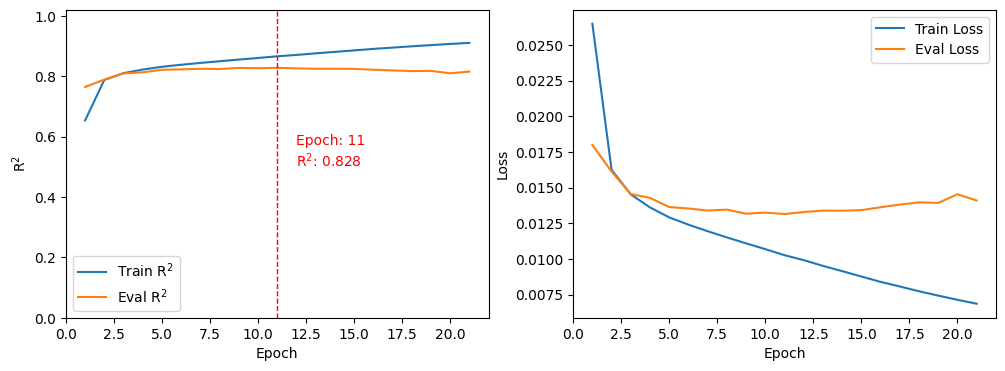

Results for esm2_150M_LoRa_cls_bs64_lora_pfet_R8_A16_DP0.2_M_k_q_v/tail_stability_scaled_factor_13/training_history.pkl


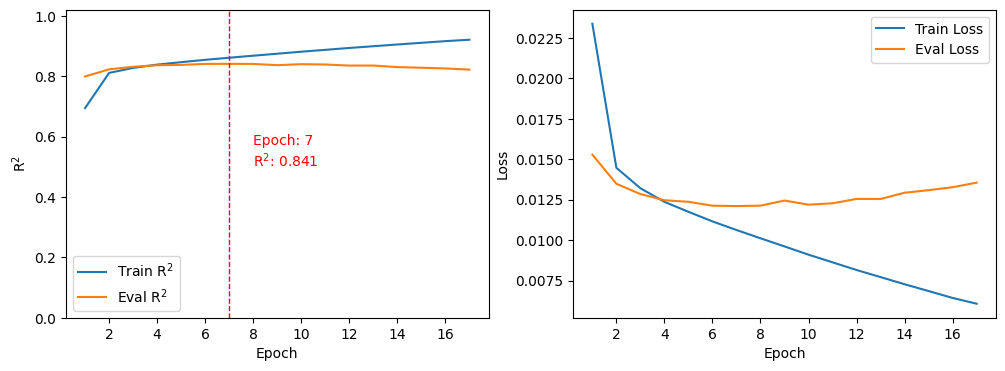

Results for esm2_150M_LoRa_cls_bs64_lora_pfet_R4_A8_DP0.2_M_q_v/tail_stability_scaled_factor_13/training_history.pkl


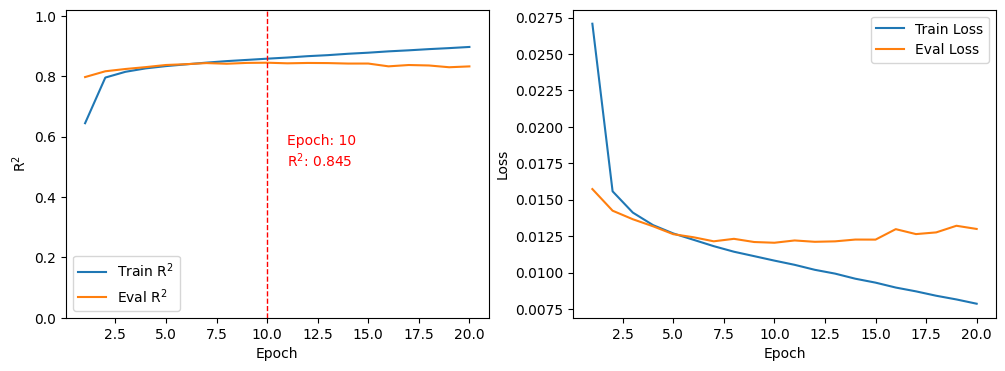

Results for esm2_150M_LoRa_cls_bs64_lora_pfet_R8_A16_DP0.2_M_q_v/tail_stability_scaled_factor_13/training_history.pkl


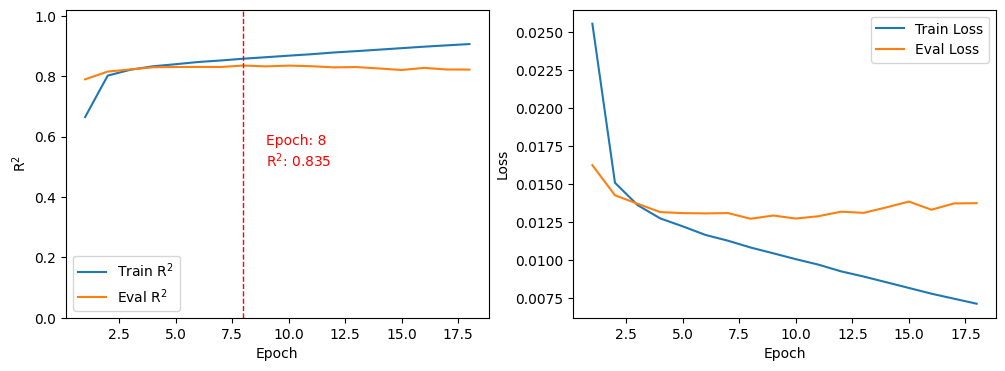

In [5]:
dataset = 'tail'
for check in os.listdir('results/finetune/checkpoints/'):
    for folder in os.listdir(f'results/finetune/checkpoints/{check}'):
        if dataset in folder:
            for file in os.listdir(f'results/finetune/checkpoints/{check}/{folder}'):
                if 'training_history' in file:
                    history_file = f'results/finetune/checkpoints/{check}/{folder}/{file}'
                    print(f'Results for {check}/{folder}/{file}' )
                    plot_results_reg(history_file)

In [46]:
res = pd.read_csv('results/tail/predictions_finetune_factor_13_tail.csv')
res.head()

,ID,sequence,stability,prediction
0,mut_94445,SATPLKIQGTEEGIRIFSKVKYYNVE,0.569231,0.419148
1,mut_101584,KCDLEDERVVGKEQGQNLARQWCNCAFLESSTKSKIR,0.630769,0.519262
2,mut_9715,SQNLSRFFPEAMSSLMRPCPRTAGCSSTAWRGSAVLAN,0.061538,0.055268
3,mut_124325,KLAYPEVEESKFKRRRG,0.815385,0.723727
4,mut_79085,AEKCGPPPPIDNGDITSFLLSVYAPGSSVEYQCQNLR,0.438462,0.393115


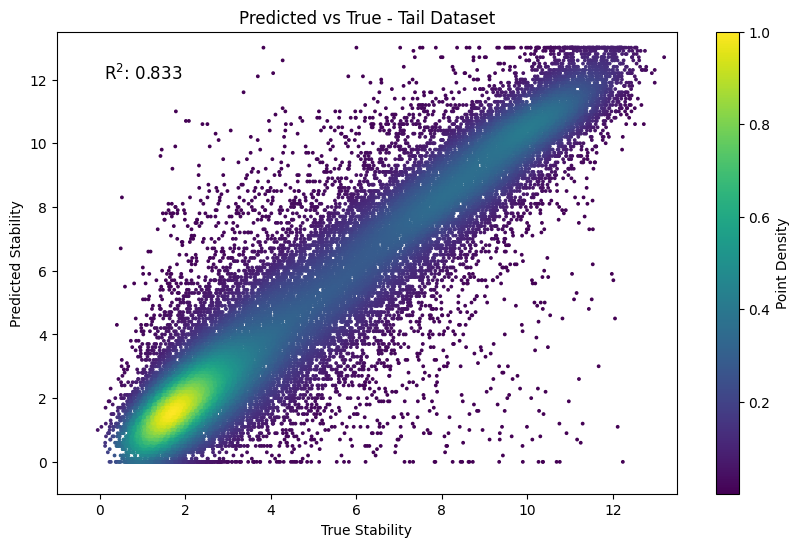

In [50]:

targets = res['targets'].values
preds = res['preds'].values

title = 'Predicted vs True - Tail Dataset'
out_file = 'results/tail/predictions_finetune_density_plot_stability_tail.png'
plot_predictions(targets, preds, 13, title=title, out_file=out_file)

## Stability Independent Initiation C

Results for esm2_150M_LoRa_cls_bs64_lora_pfet_R4_A8_DP0.2_M_k_q_v/StaUbiInd_C_scaled_factor_13.0/training_history.pkl


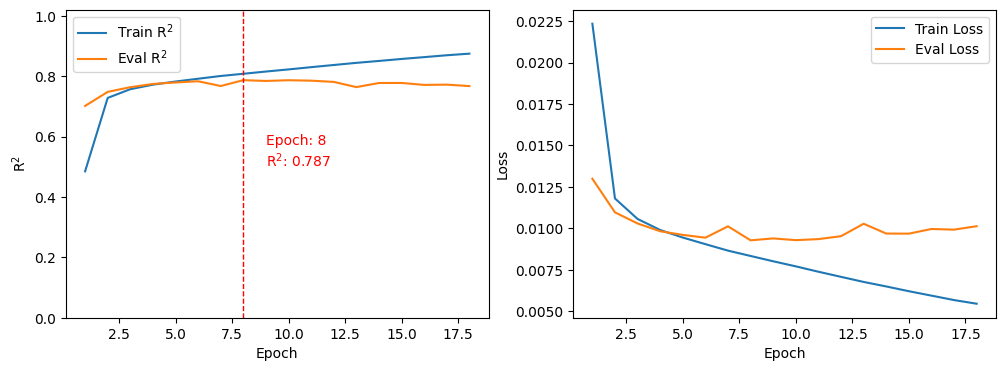

Results for esm2_150M_LoRa_cls_bs64_lora_pfet_R8_A16_DP0.2_M_k_q_v/StaUbiInd_C_scaled_factor_13.0/training_history.pkl


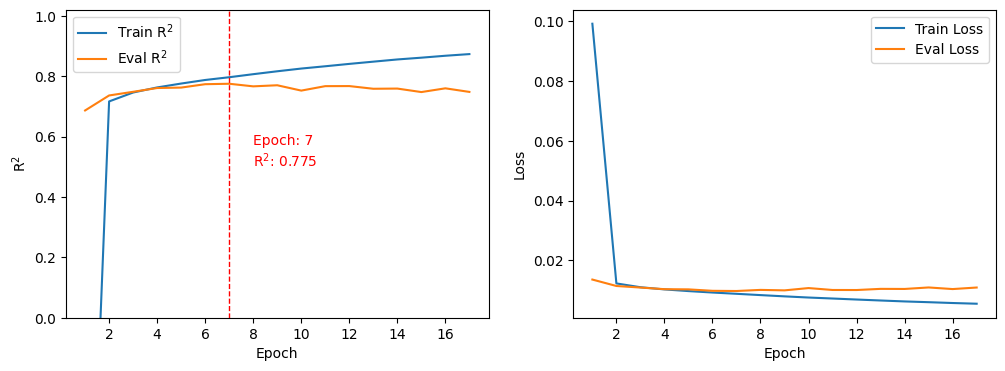

Results for esm2_150M_LoRa_cls_bs64_lora_pfet_R4_A8_DP0.2_M_q_v/StaUbiInd_C_scaled_factor_13.0/training_history.pkl


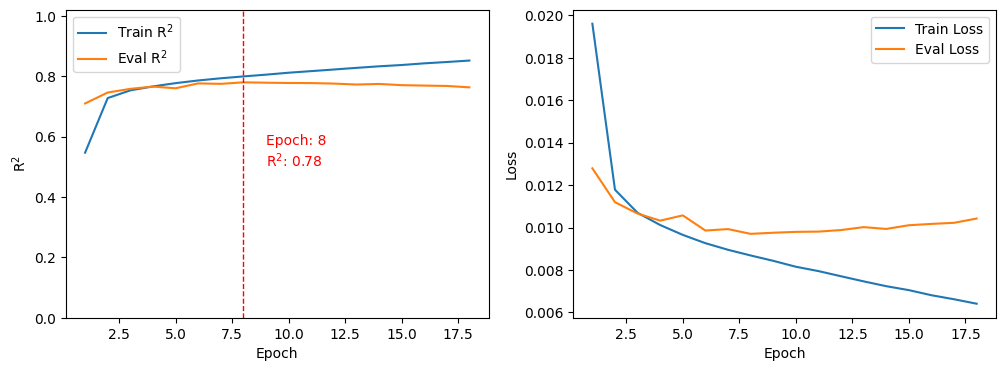

Results for esm2_150M_LoRa_cls_bs64_lora_pfet_R8_A16_DP0.2_M_q_v/StaUbiInd_C_scaled_factor_13.0/training_history.pkl


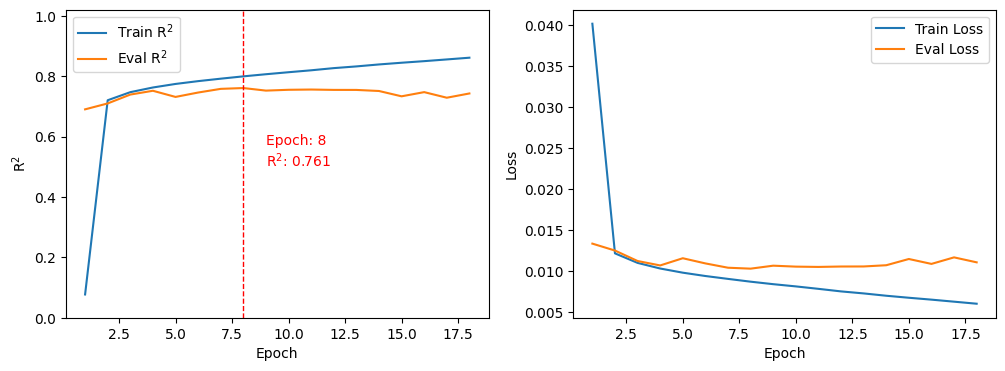

In [68]:
dataset = dataset = 'StaUbiInd_C'
for check in os.listdir('results/finetune/checkpoints/'):
    for folder in os.listdir(f'results/finetune/checkpoints/{check}'):
        if dataset in folder:
            for file in os.listdir(f'results/finetune/checkpoints/{check}/{folder}'):
                if 'training_history' in file:
                    history_file = f'results/finetune/checkpoints/{check}/{folder}/{file}'
                    print(f'Results for {check}/{folder}/{file}' )
                    plot_results_reg(history_file)


In [80]:
res = pd.read_csv('results/independent/predictions_factor_13_StaUbiInd_C.csv')
res.head()

,ID,sequence,stability_C,prediction
0,mut_82578,MEYASDASLDPEAPWPPAPRARACRVLPWALVAGLPR,0.530769,0.450428
1,mut_1399,ADCAHELRRHGVSCVSLWPGIVQTELLKAHMAKEEIR,0.453846,0.484387
2,mut_115747,QGEFIEMKSNLKHLEVLLLSRVRSSSSCVSSWAS,0.523077,0.476362
3,mut_149587,TEKDLLIYDSMPRRKEAWFSPVHTYPLLATRLVHSGR,0.307692,0.366900
4,mut_119643,QQALTNLQLPQPAFIPAGPILCWHRLQILCR,0.361538,0.221022


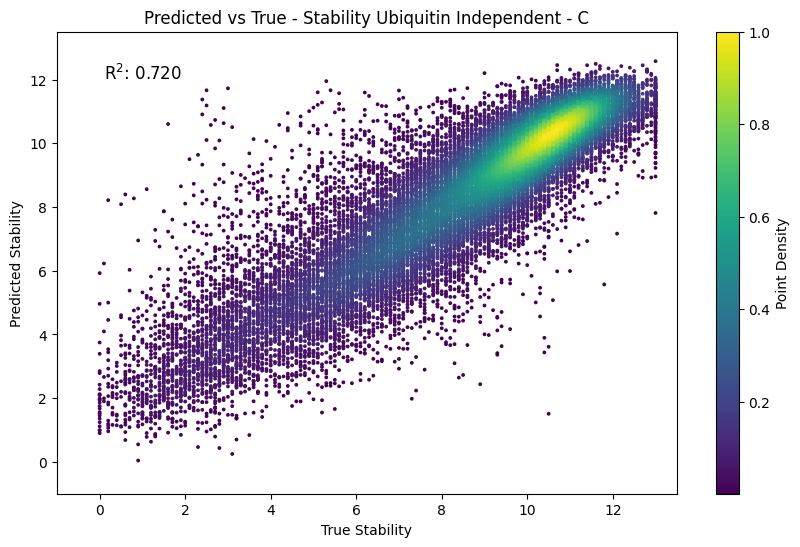

In [81]:
targets = res['stability_C'].values
preds = res['prediction'].values

title = 'Predicted vs True - Stability Ubiquitin Independent - C'
out_file = 'results/independent/predictions_finetune_density_plot_stability_StaUbiInd_C.png'
plot_predictions(targets, preds, 13, title=title, out_file=out_file)

# Stability Independent Initiation - H

Results for esm2_150M_LoRa_cls_bs64_lora_pfet_R4_A8_DP0.2_M_k_q_v/StaUbiInd_H_scaled_factor_13.0/training_history.pkl


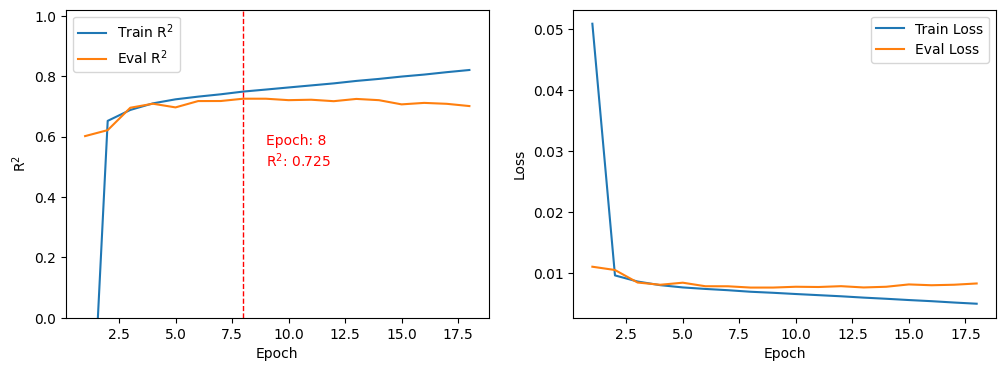

Results for esm2_150M_LoRa_cls_bs64_lora_pfet_R8_A16_DP0.2_M_k_q_v/StaUbiInd_H_scaled_factor_13.0/training_history.pkl


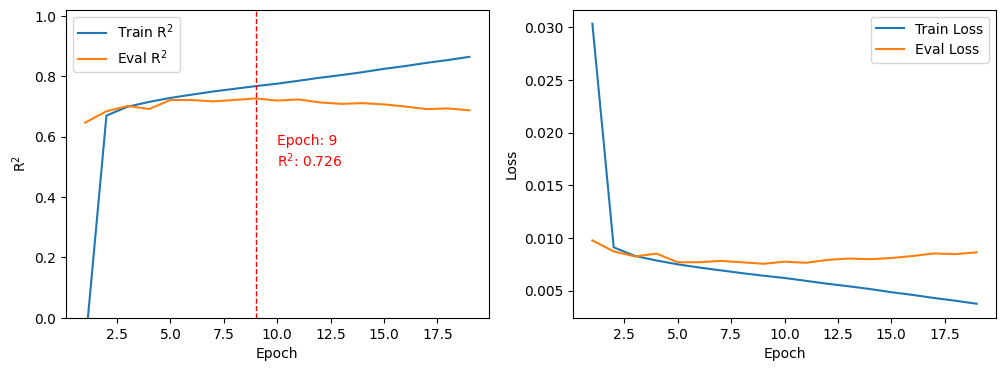

Results for esm2_150M_LoRa_cls_bs64_lora_pfet_R4_A8_DP0.2_M_q_v/StaUbiInd_H_scaled_factor_13.0/training_history.pkl


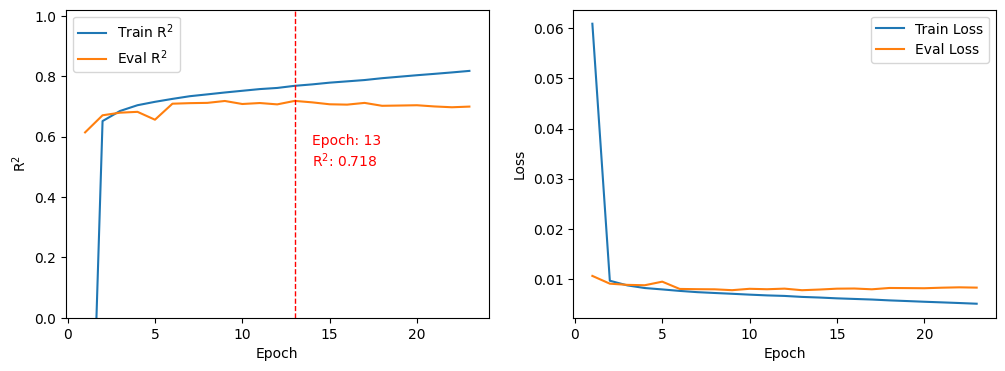

Results for esm2_150M_LoRa_cls_bs64_lora_pfet_R8_A16_DP0.2_M_q_v/StaUbiInd_H_scaled_factor_13.0/training_history.pkl


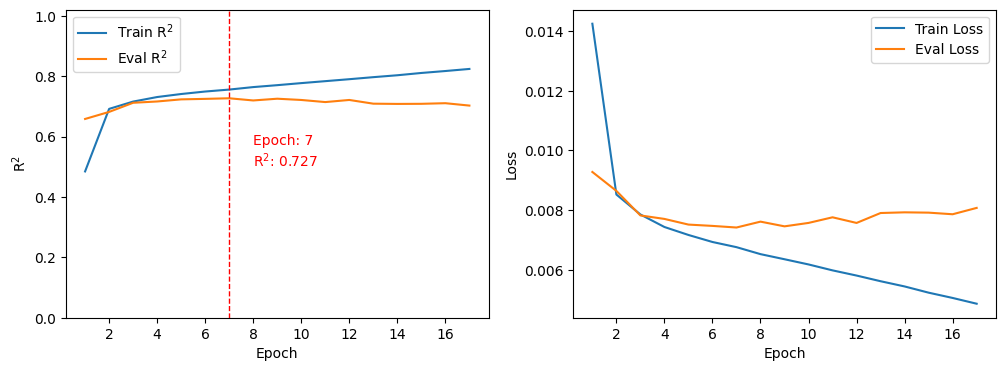

In [6]:
dataset = 'StaUbiInd_H'
for check in os.listdir('results/finetune/checkpoints/'):
    for folder in os.listdir(f'results/finetune/checkpoints/{check}'):
        if dataset in folder:
            for file in os.listdir(f'results/finetune/checkpoints/{check}/{folder}'):
                if 'training_history' in file:
                    history_file = f'results/finetune/checkpoints/{check}/{folder}/{file}'
                    print(f'Results for {check}/{folder}/{file}' )
                    plot_results_reg(history_file)

In [7]:
res = pd.read_csv('results/independent/predictions_factor_13_StaUbiInd_H.csv')
res.head()

,ID,sequence,stability_H,prediction
0,mut_82578,MEYASDASLDPEAPWPPAPRARACRVLPWALVAGLPR,0.523077,0.514560
1,mut_1399,ADCAHELRRHGVSCVSLWPGIVQTELLKAHMAKEEIR,0.584615,0.531180
2,mut_115747,QGEFIEMKSNLKHLEVLLLSRVRSSSSCVSSWAS,0.392308,0.534298
3,mut_149587,TEKDLLIYDSMPRRKEAWFSPVHTYPLLATRLVHSGR,0.423077,0.488841
4,mut_119643,QQALTNLQLPQPAFIPAGPILCWHRLQILCR,0.161538,0.274067


0.6293775769683754


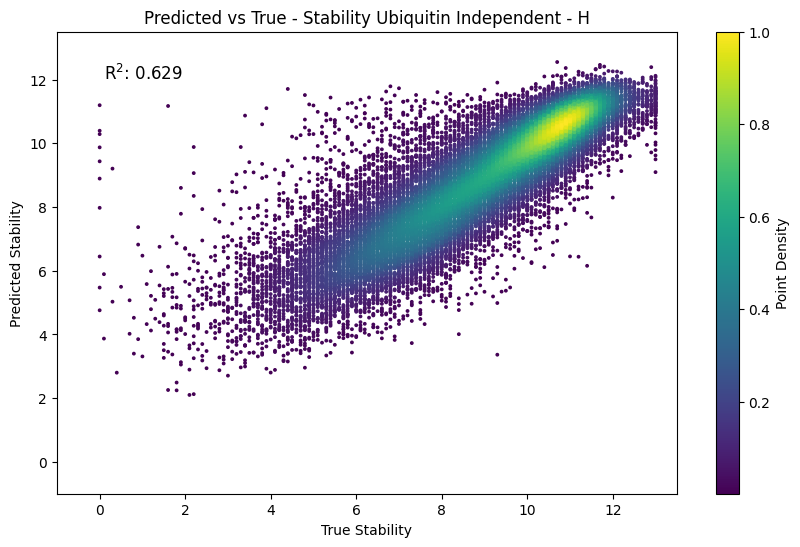

In [8]:
targets = res['stability_H'].values
preds = res['prediction'].values
print(r2_score(preds, targets))

title = 'Predicted vs True - Stability Ubiquitin Independent - H'
out_file = 'results/independent/predictions_finetune_density_plot_stability_StaUbiInd_H.png'
plot_predictions(targets, preds, 13, title=title, out_file=out_file)

# Stability Internal Initiation with Linker - BFP

Results for esm2_150M_LoRa_cls_bs64_lora_pfet_R4_A8_DP0.2_M_k_q_v/StaIntIni_Linker_BFP_scaled_factor_10.0/training_history.pkl


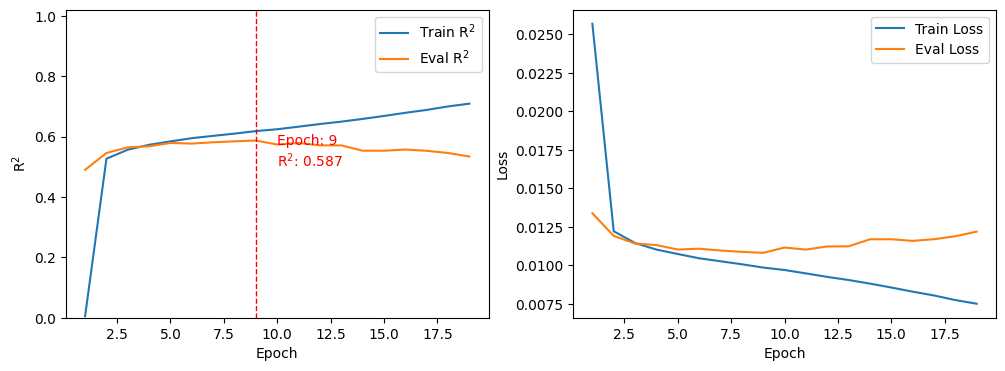

Results for esm2_150M_LoRa_cls_bs64_lora_pfet_R8_A16_DP0.2_M_k_q_v/StaIntIni_Linker_BFP_scaled_factor_10.0/training_history.pkl


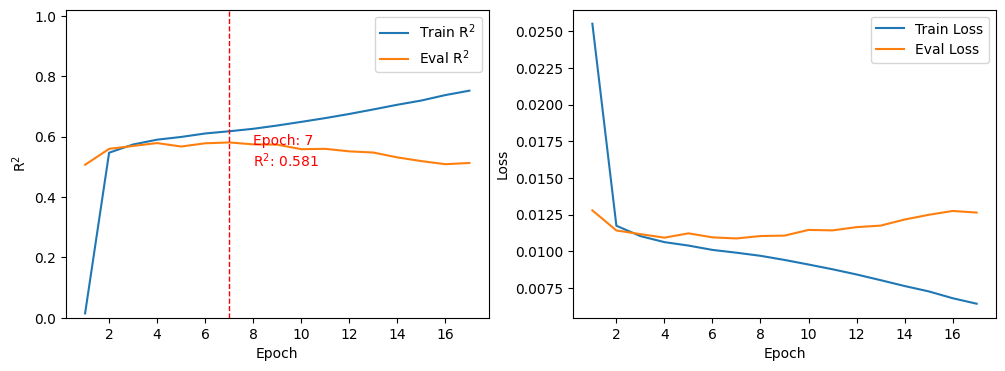

Results for esm2_150M_LoRa_cls_bs64_lora_pfet_R4_A8_DP0.2_M_q_v/StaIntIni_Linker_BFP_scaled_factor_10.0/training_history.pkl


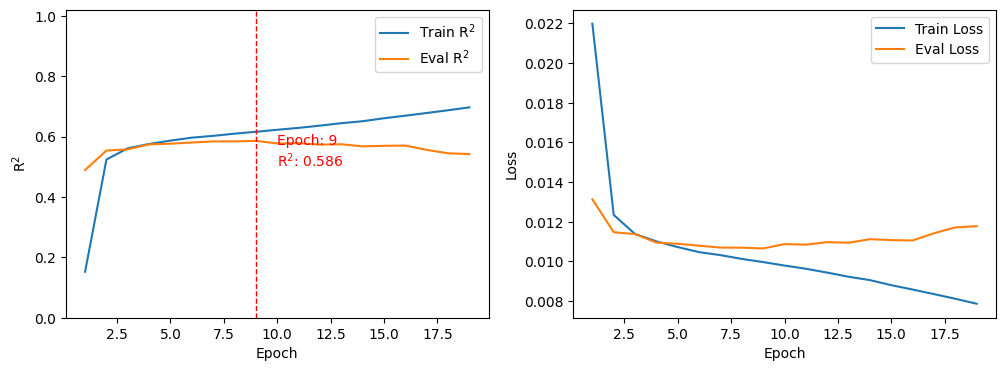

Results for esm2_150M_LoRa_cls_bs64_lora_pfet_R8_A16_DP0.2_M_q_v/StaIntIni_Linker_BFP_scaled_factor_10.0/training_history.pkl


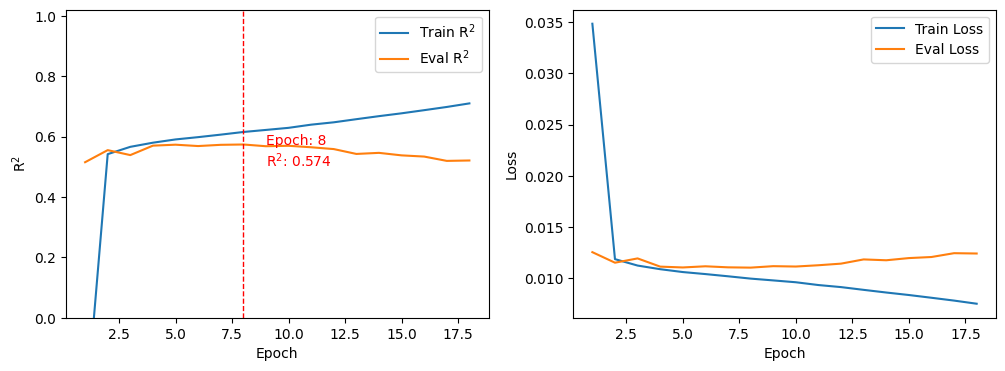

In [85]:
dataset = 'StaIntIni_Linker_BFP'
for check in os.listdir('results/finetune/checkpoints/'):
    for folder in os.listdir(f'results/finetune/checkpoints/{check}'):
        if dataset in folder:
            for file in os.listdir(f'results/finetune/checkpoints/{check}/{folder}'):
                if 'training_history' in file:
                    history_file = f'results/finetune/checkpoints/{check}/{folder}/{file}'
                    print(f'Results for {check}/{folder}/{file}' )
                    plot_results_reg(history_file)

In [104]:
#res = pd.read_csv('data/StaIntIni_Linker_BFP_scaled_factor_10.0_test.csv')
#res['ID']  = res['ID'].apply(lambda x: 'BFP_' + str(x))
res = pd.read_csv('results/independent/predictions_factor_10_StaIntIni_Linker_BFP.csv')
res.head()

,ID,Sequence,stability_BFP,prediction
0,BFP_34503,LSAGTTRAFPLFYDAYGHRDRLPALAWLLLQDLPLP,0.56,0.585701
1,BFP_52391,PEPCQPKVPEPCQPKVPEPCPSTVTPAPAQQKTKQK,0.78,0.805601
2,BFP_2920,APVPKKLLMMAGIDDCYTSARGCTATLGNFAKATFD,0.63,0.478934
3,BFP_77722,SHQAKLPDLQPFPSPDGDTVTQHEELVWMPGVNDCD,0.81,0.707513
4,BFP_52864,PFQSEIFAKRAYRELLLLKHMQHENVIGLLDVFTPA,0.53,0.516170


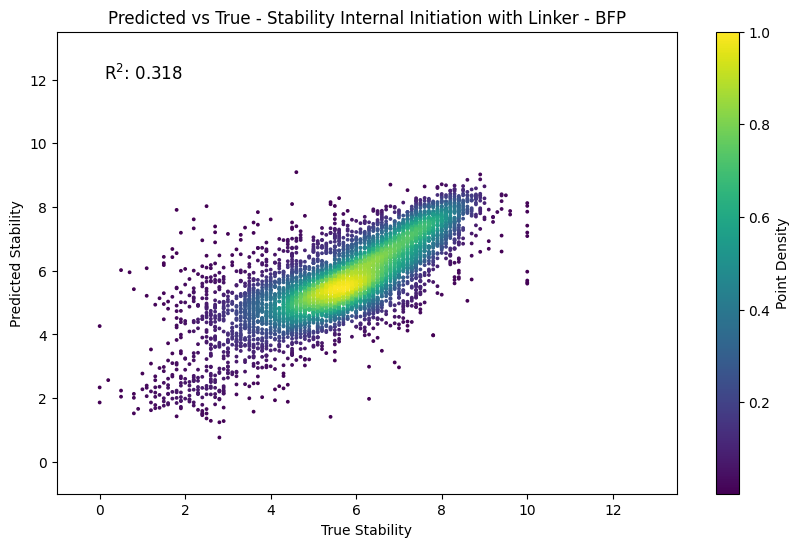

In [105]:
targets = res['stability_BFP'].values
preds = res['prediction'].values

title = 'Predicted vs True - Stability Internal Initiation with Linker - BFP'
out_file = 'results/independent/predictions_finetune_density_plot_stability_StaIntIni_Linker_BFP.png'
plot_predictions(targets, preds, 10, title=title, out_file=out_file)

## Stability Internal Initiation with Linker - YFP

Results for esm2_150M_LoRa_cls_bs64_lora_pfet_R4_A8_DP0.2_M_k_q_v/StaIntIni_Linker_YFP_scaled_factor_11.6/training_history.pkl


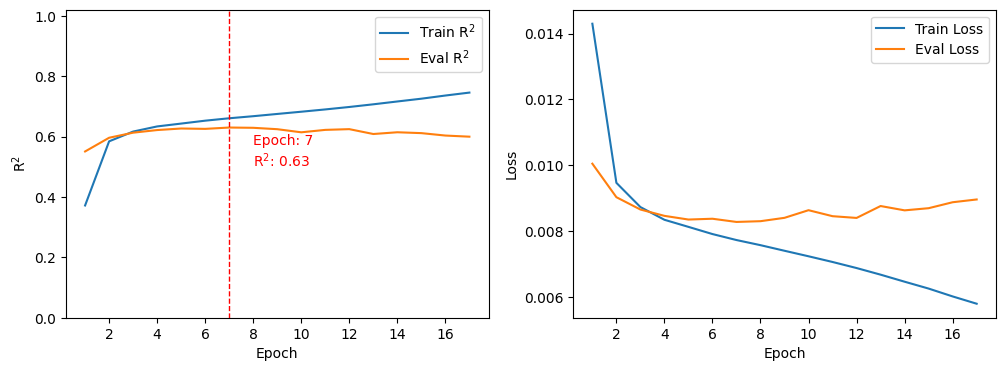

Results for esm2_150M_LoRa_cls_bs64_lora_pfet_R8_A16_DP0.2_M_k_q_v/StaIntIni_Linker_YFP_scaled_factor_11.6/training_history.pkl


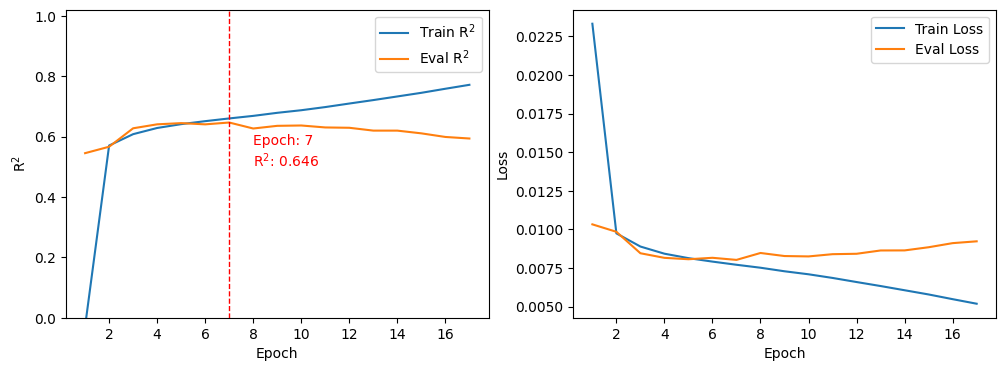

Results for esm2_150M_LoRa_cls_bs64_lora_pfet_R4_A8_DP0.2_M_q_v/StaIntIni_Linker_YFP_scaled_factor_11.6/training_history.pkl


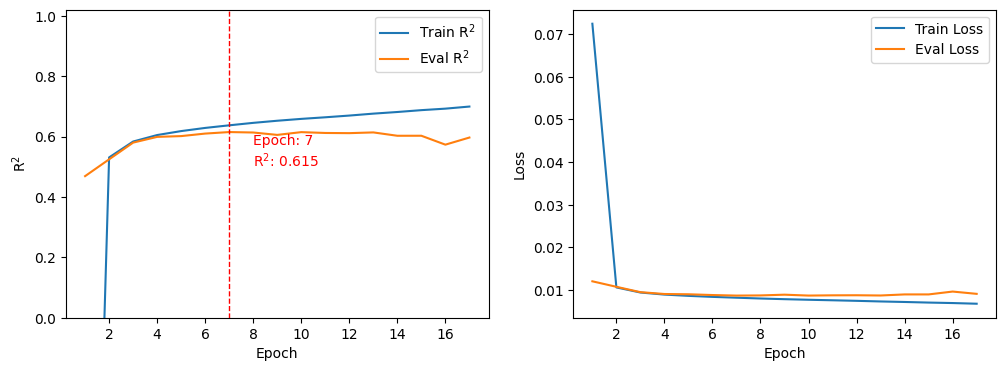

Results for esm2_150M_LoRa_cls_bs64_lora_pfet_R8_A16_DP0.2_M_q_v/StaIntIni_Linker_YFP_scaled_factor_11.6/training_history.pkl


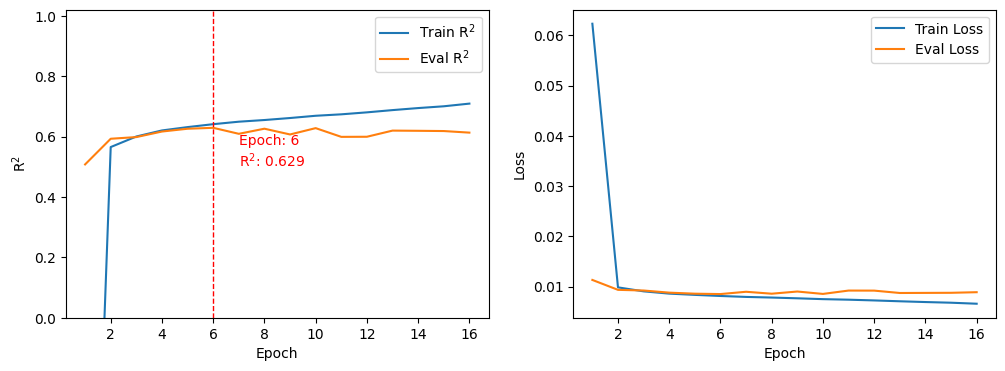

In [95]:
dataset = 'StaIntIni_Linker_YFP'
for check in os.listdir('results/finetune/checkpoints/'):
    for folder in os.listdir(f'results/finetune/checkpoints/{check}'):
        if dataset in folder:
            for file in os.listdir(f'results/finetune/checkpoints/{check}/{folder}'):
                if 'training_history' in file:
                    history_file = f'results/finetune/checkpoints/{check}/{folder}/{file}'
                    print(f'Results for {check}/{folder}/{file}' )
                    plot_results_reg(history_file)

In [97]:
# res = pd.read_csv('data/StaIntIni_Linker_YFP_scaled_factor_11.6_test.csv')
# res['ID']  = res['ID'].apply(lambda x: 'YFP_' + str(x))
# res.to_csv('data/StaIntIni_Linker_YFP_scaled_factor_11.6_test.csv', index=False)
# res.head()

,ID,Sequence,stability_YFP
0,YFP_34503,LSAGTTRAFPLFYDAYGHRDRLPALAWLLLQDLPLP,0.491379
1,YFP_52391,PEPCQPKVPEPCQPKVPEPCPSTVTPAPAQQKTKQK,0.689655
2,YFP_2920,APVPKKLLMMAGIDDCYTSARGCTATLGNFAKATFD,0.491379
3,YFP_77722,SHQAKLPDLQPFPSPDGDTVTQHEELVWMPGVNDCD,0.646552
4,YFP_52864,PFQSEIFAKRAYRELLLLKHMQHENVIGLLDVFTPA,0.491379


In [109]:
res = pd.read_csv('results/independent/predictions_factor_11.6_StaIntIni_Linker_YFP.csv')
res.head()

,ID,Sequence,stability_YFP,prediction
0,YFP_34503,LSAGTTRAFPLFYDAYGHRDRLPALAWLLLQDLPLP,0.491379,0.533939
1,YFP_52391,PEPCQPKVPEPCQPKVPEPCPSTVTPAPAQQKTKQK,0.689655,0.651123
2,YFP_2920,APVPKKLLMMAGIDDCYTSARGCTATLGNFAKATFD,0.491379,0.447276
3,YFP_77722,SHQAKLPDLQPFPSPDGDTVTQHEELVWMPGVNDCD,0.646552,0.653286
4,YFP_52864,PFQSEIFAKRAYRELLLLKHMQHENVIGLLDVFTPA,0.491379,0.459051


0.4368465809864378


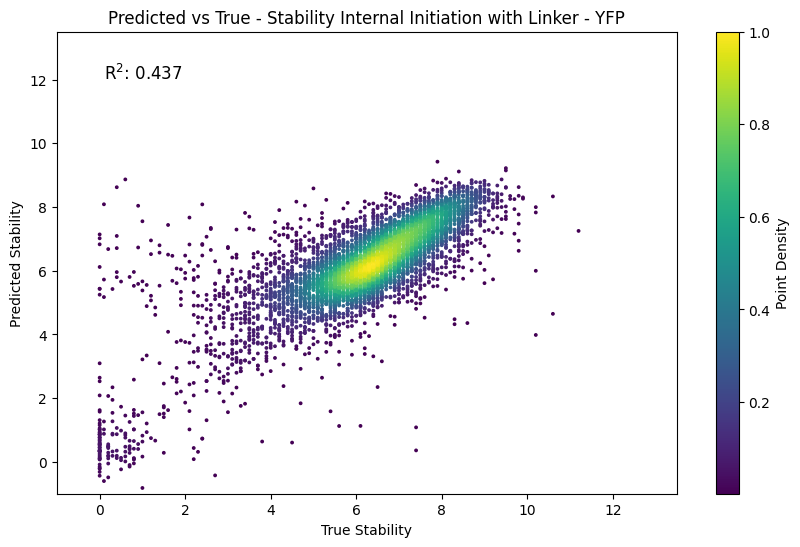

In [111]:
targets = res['stability_YFP'].values
preds = res['prediction'].values
print(r2_score(preds, targets))

title = 'Predicted vs True - Stability Internal Initiation with Linker - YFP'
out_file = 'results/independent/predictions_finetune_density_plot_stability_StaIntIni_Linker_YFP.png'
plot_predictions(targets, preds, 11.6, title=title, out_file=out_file)

## Stability Internal Initiation No Linker - BFP

Results for esm2_150M_LoRa_cls_bs64_lora_pfet_R4_A8_DP0.2_M_k_q_v/StaIntIni_noLinker_BFP_scaled_factor_10.0/training_history.pkl


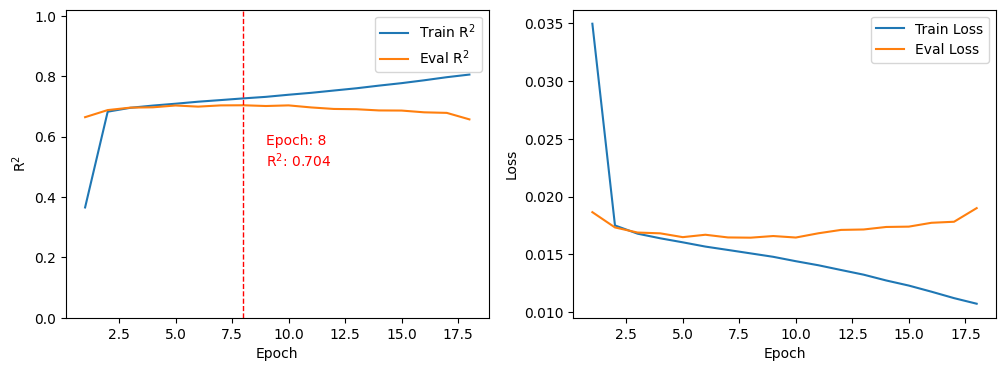

Results for esm2_150M_LoRa_cls_bs64_lora_pfet_R8_A16_DP0.2_M_k_q_v/StaIntIni_noLinker_BFP_scaled_factor_10.0/training_history.pkl


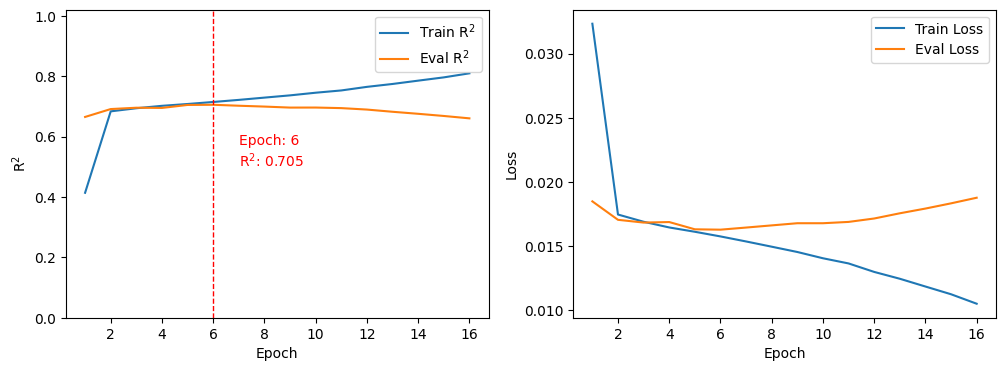

Results for esm2_150M_LoRa_cls_bs64_lora_pfet_R4_A8_DP0.2_M_q_v/StaIntIni_noLinker_BFP_scaled_factor_10.0/training_history.pkl


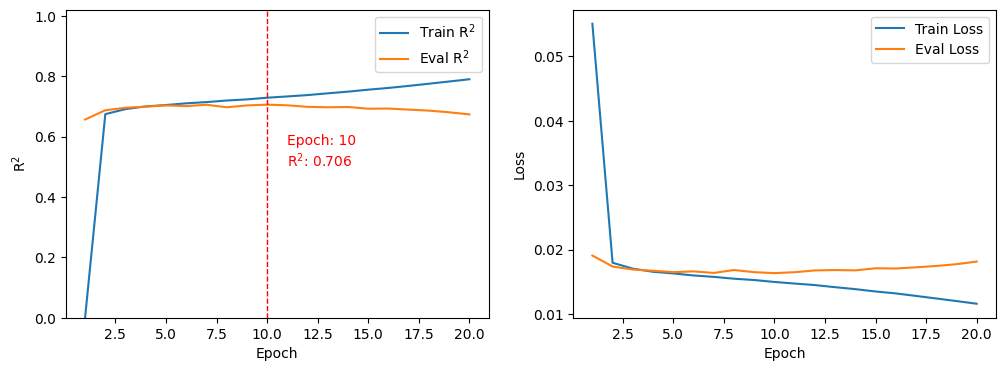

Results for esm2_150M_LoRa_cls_bs64_lora_pfet_R8_A16_DP0.2_M_q_v/StaIntIni_noLinker_BFP_scaled_factor_10.0/training_history.pkl


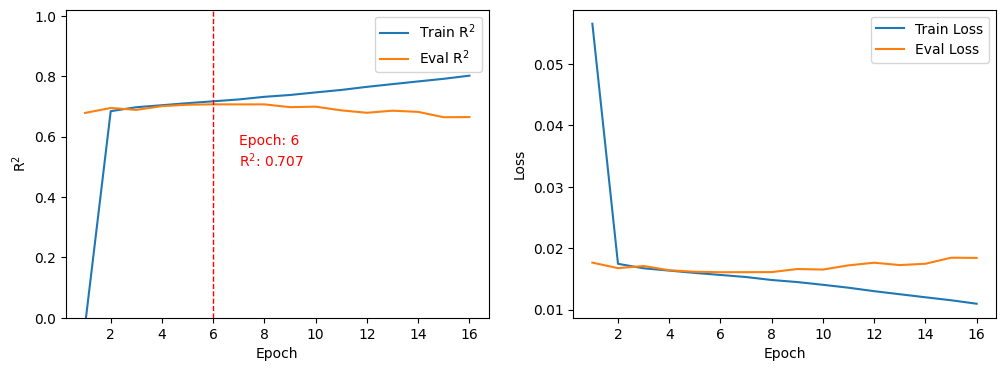

In [112]:
dataset = 'StaIntIni_noLinker_BFP'
for check in os.listdir('results/finetune/checkpoints/'):
    for folder in os.listdir(f'results/finetune/checkpoints/{check}'):
        if dataset in folder:
            for file in os.listdir(f'results/finetune/checkpoints/{check}/{folder}'):
                if 'training_history' in file:
                    history_file = f'results/finetune/checkpoints/{check}/{folder}/{file}'
                    print(f'Results for {check}/{folder}/{file}' )
                    plot_results_reg(history_file)

In [113]:
# path = 'data/StaIntIni_noLinker_BFP_scaled_factor_10.0_test.csv'
# res = pd.read_csv(path)
# res['ID']  = res['ID'].apply(lambda x: 'BFP_' + str(x))
# res.to_csv(path, index=False)
# res.head()

,ID,Sequence,stability_BFP
0,BFP_31071,LSVQVCRGQGGDGPLEPEHQGAAPRLAQRVSIWHQK,0.87
1,BFP_81602,VGGEEARPNSWPWQVSLQYSSNGKWYTPAVGP,0.26
2,BFP_58410,QIDTLSAFSREMKSLQYLNLRGNMVANLGELAKLRD,0.85
3,BFP_6234,DKDARERGSQSSDSSSSLSSHRYETPSDAIEVISPA,0.85
4,BFP_81977,VPGGWSRWSPWSWCDRSCGGGQSLRSRSCSSPPPRTASLEAA,0.41


In [116]:
res = pd.read_csv('results/independent/predictions_factor_10_StaIntIni_noLinker_BFP.csv')
res.head()

,ID,Sequence,stability_BFP,prediction
0,BFP_31071,LSVQVCRGQGGDGPLEPEHQGAAPRLAQRVSIWHQK,0.87,0.586828
1,BFP_81602,VGGEEARPNSWPWQVSLQYSSNGKWYTPAVGP,0.26,0.304370
2,BFP_58410,QIDTLSAFSREMKSLQYLNLRGNMVANLGELAKLRD,0.85,0.534486
3,BFP_6234,DKDARERGSQSSDSSSSLSSHRYETPSDAIEVISPA,0.85,0.867852
4,BFP_81977,VPGGWSRWSPWSWCDRSCGGGQSLRSRSCSSPPPRTASLEAA,0.41,0.240279


0.6063245472409491


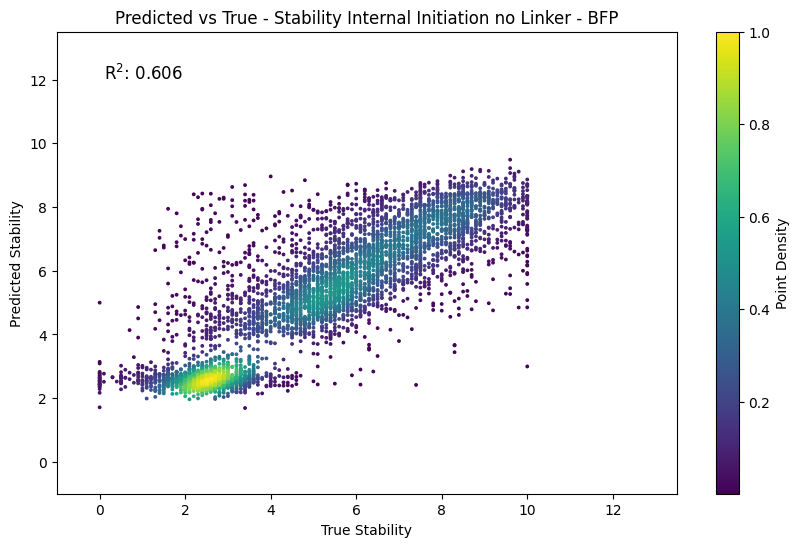

In [117]:
targets = res['stability_BFP'].values
preds = res['prediction'].values
print(r2_score(preds, targets))

title = 'Predicted vs True - Stability Internal Initiation no Linker - BFP'
out_file = 'results/independent/predictions_finetune_density_plot_stability_StaIntIni_no_BFP.png'
plot_predictions(targets, preds, 10, title=title, out_file=out_file)

## Stability Internal Initiation No Linker - YFP

Results for esm2_150M_LoRa_cls_bs64_lora_pfet_R4_A8_DP0.2_M_k_q_v/StaIntIni_noLinker_YFP_scaled_factor_11.5/training_history.pkl


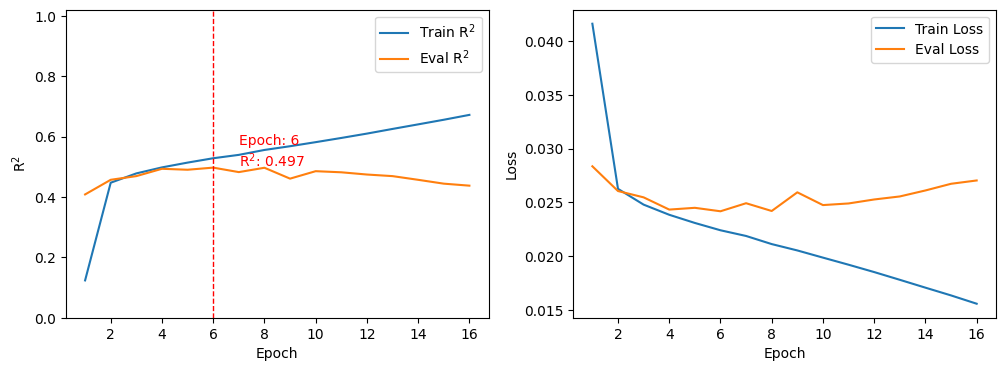

Results for esm2_150M_LoRa_cls_bs64_lora_pfet_R8_A16_DP0.2_M_k_q_v/StaIntIni_noLinker_YFP_scaled_factor_11.5/training_history.pkl


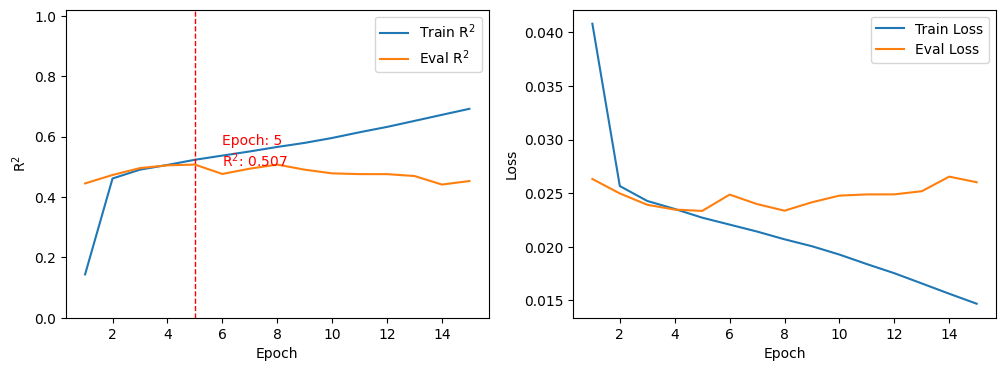

Results for esm2_150M_LoRa_cls_bs64_lora_pfet_R4_A8_DP0.2_M_q_v/StaIntIni_noLinker_YFP_scaled_factor_11.5/training_history.pkl


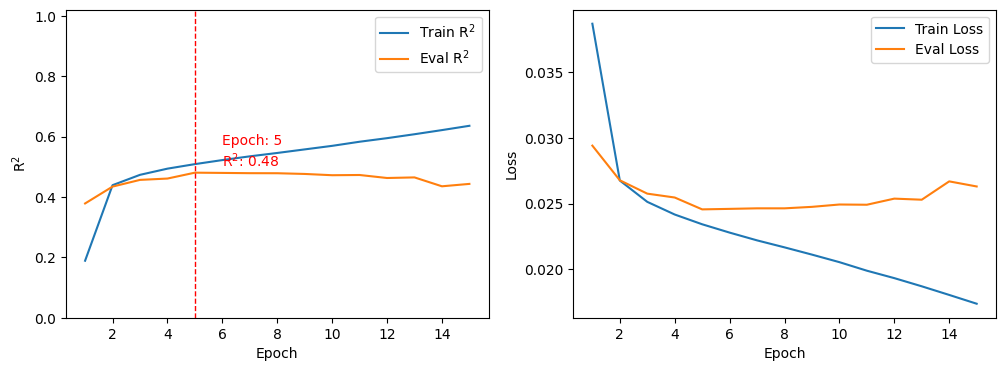

Results for esm2_150M_LoRa_cls_bs64_lora_pfet_R8_A16_DP0.2_M_q_v/StaIntIni_noLinker_YFP_scaled_factor_11.5/training_history.pkl


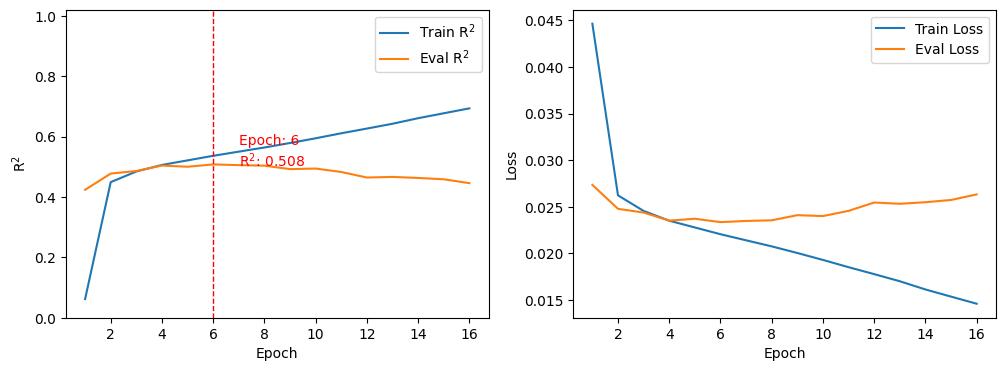

In [114]:
dataset = 'StaIntIni_noLinker_YFP'
for check in os.listdir('results/finetune/checkpoints/'):
    for folder in os.listdir(f'results/finetune/checkpoints/{check}'):
        if dataset in folder:
            for file in os.listdir(f'results/finetune/checkpoints/{check}/{folder}'):
                if 'training_history' in file:
                    history_file = f'results/finetune/checkpoints/{check}/{folder}/{file}'
                    print(f'Results for {check}/{folder}/{file}' )
                    plot_results_reg(history_file)

In [115]:
# path = 'data/StaIntIni_noLinker_YFP_scaled_factor_11.5_test.csv'
# res = pd.read_csv(path)
# res['ID']  = res['ID'].apply(lambda x: 'BFP_' + str(x))
# res.to_csv(path, index=False)
# res.head()

,ID,Sequence,stability_YFP
0,BFP_31071,LSVQVCRGQGGDGPLEPEHQGAAPRLAQRVSIWHQK,0.765217
1,BFP_81602,VGGEEARPNSWPWQVSLQYSSNGKWYTPAVGP,0.156522
2,BFP_58410,QIDTLSAFSREMKSLQYLNLRGNMVANLGELAKLRD,0.739130
3,BFP_6234,DKDARERGSQSSDSSSSLSSHRYETPSDAIEVISPA,0.791304
4,BFP_81977,VPGGWSRWSPWSWCDRSCGGGQSLRSRSCSSPPPRTASLEAA,0.052174


In [119]:
res = pd.read_csv('results/independent/predictions_factor_11.5_StaIntIni_noLinker_YFP.csv')
res.head()

,ID,Sequence,stability_YFP,prediction
0,BFP_31071,LSVQVCRGQGGDGPLEPEHQGAAPRLAQRVSIWHQK,0.765217,0.634628
1,BFP_81602,VGGEEARPNSWPWQVSLQYSSNGKWYTPAVGP,0.156522,0.398189
2,BFP_58410,QIDTLSAFSREMKSLQYLNLRGNMVANLGELAKLRD,0.739130,0.563878
3,BFP_6234,DKDARERGSQSSDSSSSLSSHRYETPSDAIEVISPA,0.791304,0.798256
4,BFP_81977,VPGGWSRWSPWSWCDRSCGGGQSLRSRSCSSPPPRTASLEAA,0.052174,0.085115


0.004122387862881771


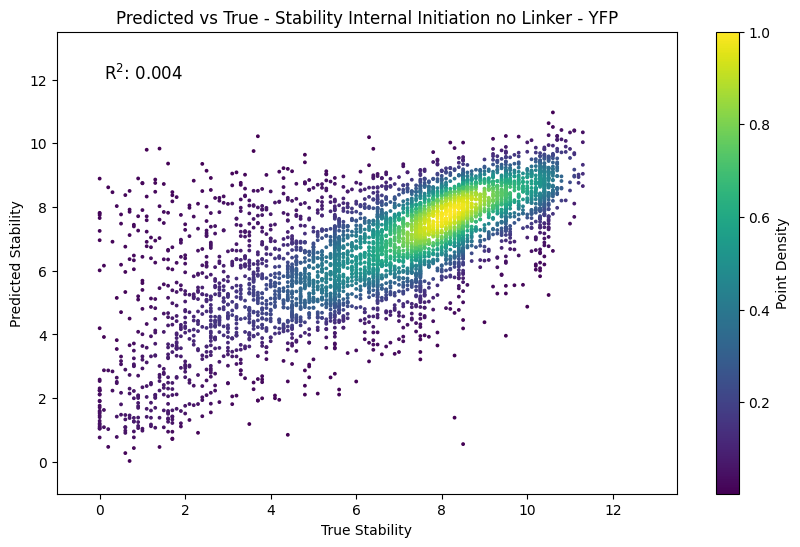

In [121]:
targets = res['stability_YFP'].values
preds = res['prediction'].values
print(r2_score(preds, targets))

title = 'Predicted vs True - Stability Internal Initiation no Linker - YFP'
out_file = 'results/independent/predictions_finetune_density_plot_stability_StaIntIni_no_Linker_YFP.png'
plot_predictions(targets, preds, 11.5, title=title, out_file=out_file)